In [1]:
import numpy as np
import matplotlib.pyplot as plt
import raster_tools as rt
import geopandas as gpd
import sys

#### Random ee stuff

In [3]:
import datetime
import ee
import geemap
import yaml
from tqdm import tqdm
import sys
from pathlib import Path
import time

ee.Initialize()


In [14]:
tasks = str(ee.batch.Task.list()).count('READY')

In [16]:
str(ee.batch.Task.list()).count('READY')

1476

#### Fire Points

##### SUOMI VIIRS

In [3]:
suomi_viirs_points = gpd.read_file('data/SUOMI_VIIRS_C2/fire_archive_SV-C2_574505.shp')

In [ ]:
suomi_viirs_points.CONFIDENCE.value_counts()

In [7]:
suomi_viirs_points

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,19.38371,-155.04800,332.81,0.43,0.62,2012-02-01,0014,N,VIIRS,n,2,295.55,11.02,D,0,POINT (-155.04800 19.38371)
1,39.93787,-76.81411,302.25,0.68,0.74,2012-02-01,0553,N,VIIRS,n,2,276.64,0.94,N,2,POINT (-76.81411 39.93787)
2,40.48211,-74.32283,299.34,0.51,0.66,2012-02-01,0553,N,VIIRS,n,2,271.78,0.70,N,2,POINT (-74.32283 40.48211)
3,39.21915,-76.48728,297.28,0.65,0.73,2012-02-01,0554,N,VIIRS,n,2,278.75,1.81,N,0,POINT (-76.48728 39.21915)
4,39.21233,-76.48756,303.34,0.65,0.73,2012-02-01,0554,N,VIIRS,n,2,277.53,0.98,N,0,POINT (-76.48756 39.21233)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553540,44.33542,-119.69381,327.02,0.71,0.75,2024-09-30,2202,N,VIIRS,n,2,288.67,60.36,D,0,POINT (-119.69381 44.33542)
6553541,44.33530,-119.68279,208.00,0.71,0.75,2024-09-30,2202,N,VIIRS,l,2,323.47,177.33,D,0,POINT (-119.68279 44.33530)
6553542,44.34235,-119.67990,345.15,0.71,0.75,2024-09-30,2202,N,VIIRS,n,2,292.06,18.32,D,0,POINT (-119.67990 44.34235)
6553543,48.39992,-121.78659,327.06,0.58,0.70,2024-09-30,2204,N,VIIRS,n,2,283.15,3.73,D,0,POINT (-121.78659 48.39992)


In [8]:
# create a dictionary of dataframe.  each key will be an ACQ_DATE and the value will be a dataframe of all the fires on that date
fire_dict = {}
for date in suomi_viirs_points.ACQ_DATE.unique():
    fire_dict[date] = suomi_viirs_points[suomi_viirs_points.ACQ_DATE == date]

<Axes: >

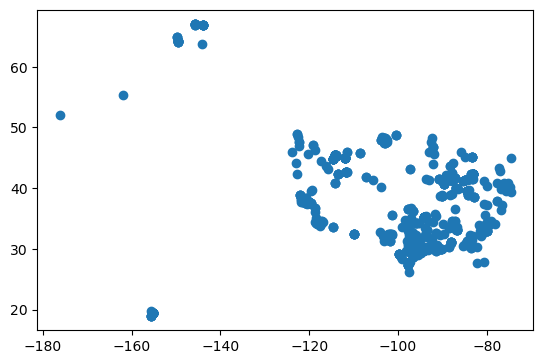

In [17]:
fire_dict['2022-07-25'].plot()

##### VIIRS J1V C2

In [2]:
viirs_af_points = gpd.read_file('data/viirs_af_points/fire_nrt_J1V-C2_572603.shp')

In [ ]:
viirs_af_points.CONFIDENCE.value_counts()

In [17]:
viirs_af_filter_low = viirs_af_points[viirs_af_points.CONFIDENCE != 'l']

In [ ]:
viirs_af_filter_low

In [25]:
import geopandas as gpd
from shapely.ops import unary_union
import pandas as pd
from datetime import timedelta

def cluster_fires(gdf, distance_threshold_meters=2000, time_threshold_hours=1):
    """Cluster fire points based on spatial and temporal proximity"""
    
    # Ensure input is in WGS84
    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    
    # Project to NAD83 Conus Albers for accurate distance measurements
    gdf_projected = gdf.to_crs('EPSG:5070')
    
    # Convert time columns to datetime
    gdf_projected['acq_datetime'] = pd.to_datetime(gdf_projected['ACQ_DATE'] + gdf_projected['ACQ_TIME'].astype(str).str.zfill(4), 
                                                 format='%Y-%m-%d%H%M')
    
    clusters = []
    for date, day_gdf in gdf_projected.groupby(gdf_projected['acq_datetime'].dt.date):
        points_processed = set()
        
        for idx1, row1 in day_gdf.iterrows():
            if idx1 in points_processed:
                continue
            
            nearby_mask = day_gdf.geometry.distance(row1.geometry) <= distance_threshold_meters
            nearby_points = day_gdf[nearby_mask]
            
            time_mask = (nearby_points['acq_datetime'] - row1['acq_datetime']).abs() <= timedelta(hours=time_threshold_hours)
            cluster_points = nearby_points[time_mask]
            
            if not cluster_points.empty:
                cluster_geom = unary_union(cluster_points.geometry)
                centroid = cluster_geom.centroid
                
                # Create a temporary GeoDataFrame with the centroid to reproject back to WGS84
                centroid_gdf = gpd.GeoDataFrame(geometry=[centroid], crs='EPSG:5070')
                centroid_wgs84 = centroid_gdf.to_crs('EPSG:4326').geometry[0]
                
                clusters.append({
                    'geometry': centroid_wgs84,
                    'lat': centroid_wgs84.y,
                    'lon': centroid_wgs84.x,
                    'start_time': cluster_points['acq_datetime'].min(),
                    'end_time': cluster_points['acq_datetime'].max(),
                    'num_points': len(cluster_points)
                })
                
                points_processed.update(cluster_points.index)
    
    # Return the clusters in WGS84
    return gpd.GeoDataFrame(clusters, crs='EPSG:4326')

# Usage:
viirs_af_clusters = cluster_fires(viirs_af_filter_low)

In [ ]:
viirs_af_clusters.num_points.value_counts()

#### Fire Rasters

In [2]:
fire_2022 = rt.Raster("data/download/Image_Export_fire_TX2966909410420221109_2022-11-02.tif")

In [28]:
fire_2021 = rt.Raster("data/wfspreadts_orig/2021/fire_24935867/2021-02-12.tif")

In [ ]:
fire_2022.xdata.long_name.index('active fire')

In [ ]:
len(fire_2022.xdata.long_name)

In [ ]:
fire_2022.get_bands(fire_2022.xdata.long_name.index('active fire')+1).mean().compute()

In [ ]:
fire_2021.xdata.long_name.index('active fire')

In [ ]:
fire_2022.xdata.long_name

In [ ]:
fire_2022.get_bands(fire_2022.xdata.long_name.index('active fire')).mean().compute()

In [ ]:
# path to the raster file: data/2018/fire_21458798/2018-01-01.tif

# fire2018_01_01 = rt.Raster('data/2018/fire_21458798/2018-01-01.tif')
# fire2018_01_01_hd5 = rt.open_vectors('hd5data/2018/fire_21458798.hd5')

In [ ]:
# fire2018_01_01_hd5.xdata